## Prophet Model for Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\anshh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
demand = pd.read_csv('product_demand.csv')
demand

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [3]:
demand.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [4]:
demand['Date'] = pd.to_datetime(demand['Date'])
# demand['Order_Demand'] = demand['Order_Demand'].str.replace('[^0-9-]','').astype(int)
# demand.dtypes
demand.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [5]:
#selecting a category
category = demand['Product_Category'].unique()
category.sort()
print(category)
#selecting a product from a category
products = demand[demand['Product_Category'] == category[0]]['Product_Code'].unique()
print(products)

['Category_001' 'Category_002' 'Category_003' 'Category_004'
 'Category_005' 'Category_006' 'Category_007' 'Category_008'
 'Category_009' 'Category_010' 'Category_011' 'Category_012'
 'Category_013' 'Category_014' 'Category_015' 'Category_016'
 'Category_017' 'Category_018' 'Category_019' 'Category_020'
 'Category_021' 'Category_022' 'Category_023' 'Category_024'
 'Category_025' 'Category_026' 'Category_027' 'Category_028'
 'Category_029' 'Category_030' 'Category_031' 'Category_032'
 'Category_033']
['Product_1938' 'Product_0613' 'Product_1763' 'Product_0616'
 'Product_0623' 'Product_0620' 'Product_1757' 'Product_0608'
 'Product_1752' 'Product_1755' 'Product_0601' 'Product_1935'
 'Product_0617' 'Product_1859' 'Product_0261' 'Product_0614'
 'Product_0622' 'Product_1870' 'Product_0631' 'Product_0632'
 'Product_1762' 'Product_1754' 'Product_1760' 'Product_0609'
 'Product_0405' 'Product_1869' 'Product_1875' 'Product_1861'
 'Product_0627' 'Product_0625' 'Product_0629' 'Product_0791'
 'Produ

In [6]:
# creating dataset for a single product
df = demand.loc[(demand['Product_Code'] == products[0]) & (demand['Product_Category'] == category[0]), ['Date','Order_Demand']].reset_index(drop=True)
# df.set_index('Date', inplace=True)
# print(df['Product_Category'].unique().shape[0] == df.shape[0])
df['Order_Demand'] = df['Order_Demand'].str.replace('[^0-9-]', '').apply(pd.to_numeric)
print(df.dtypes)
df.head()
df.dtypes
df.describe()

Date            datetime64[ns]
Order_Demand             int64
dtype: object


,Order_Demand
count,929.000000
mean,4.410118
std,4.765260
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,40.000000


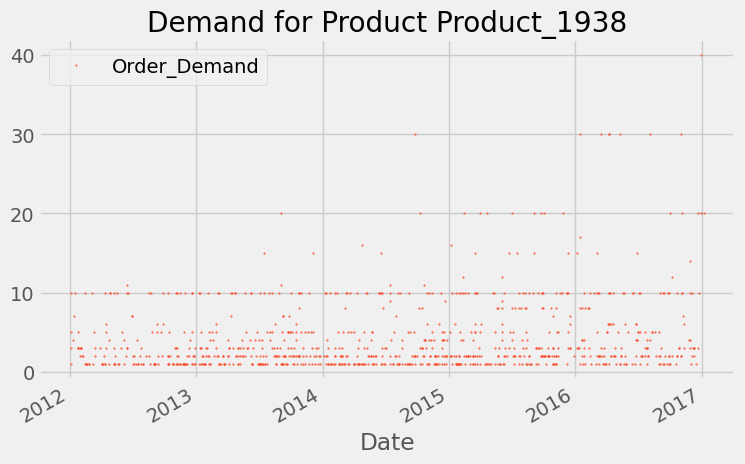

In [7]:
#plotting demand for a single product
color_pal = sns.color_palette()
df.plot(style='.',
          figsize=(8, 5),
          ms=1,
          color=color_pal[1],
          title='Demand for Product {}'.format(products[0]),x='Date',y='Order_Demand')
plt.show()

In [8]:
# function to add features to the dataset
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.Date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

# X, y = create_features(df, label='df_MW')
# features_and_target = pd.concat([X, y], axis=1)

In [9]:
X, y = create_features(df, label='Order_Demand')
features_target = pd.concat([X, y], axis=1)
features_target.head()
# demand['Order_Demand'] = demand['Order_Demand'].str.replace('[^0-9-]','').astype(int)
# features_target['Order_Demand'] = features_target['Order_Demand'].str.replace('[^0-9-]','').apply(np.int64)
print(features_target.dtypes)
features_target.head()

hour               int64
dayofweek          int64
quarter            int64
month              int64
year               int64
dayofyear          int64
dayofmonth         int64
weekofyear         int64
weekday         category
season          category
Order_Demand       int64
dtype: object


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Order_Demand
0,0,2,2,6,2012,158,6,23,Wednesday,Spring,4
1,0,4,3,7,2012,195,13,28,Friday,Summer,4
2,0,3,4,12,2012,348,13,50,Thursday,Fall,4
3,0,2,4,12,2012,347,12,50,Wednesday,Fall,3
4,0,0,2,4,2012,114,23,17,Monday,Spring,4


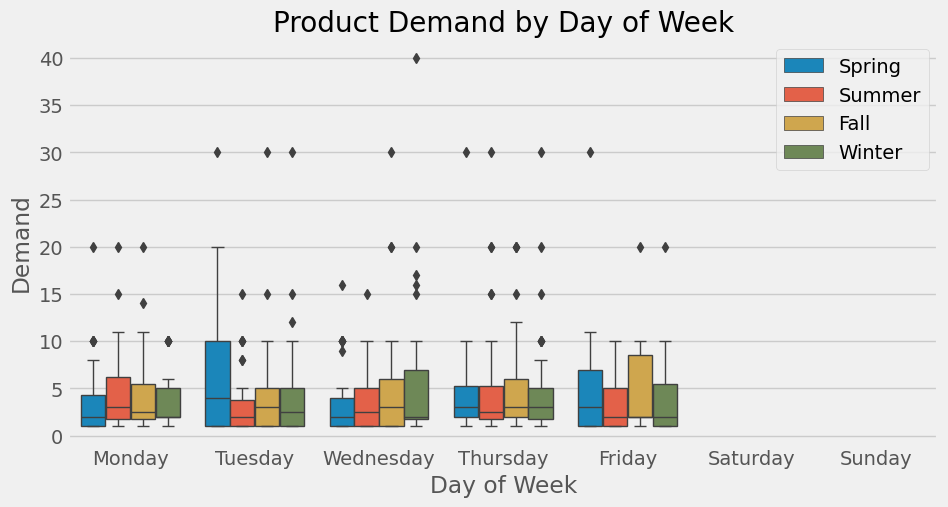

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_target.dropna(),
            x='weekday',
            y='Order_Demand',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Product Demand by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Demand')
# plt.ylim(0, features_target['Order_Demand'].max())
ax.legend(bbox_to_anchor=(1, 1))
plt.show()
#changing scale of y-axis

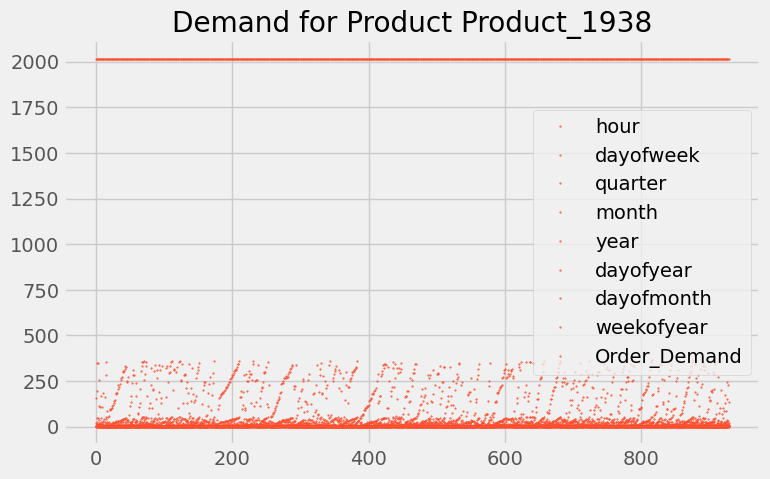

In [11]:
#plotting demand for a single product
color_pal = sns.color_palette()
features_target.plot(style='.',
          figsize=(8, 5),
          ms=1,
          color=color_pal[1],
          title='Demand for Product {}'.format(products[0]))
plt.show()

In [12]:
#replacing index with date
# df.set_index('Date', inplace=True)
# df.index = pd.to_datetime(df.index)
# df.head()
df
# df['Order_Demand'] = df['Order_Demand'].str.replace('[^0-9-]','').apply(np.int64)
df.dtypes

Date            datetime64[ns]
Order_Demand             int64
dtype: object

(0.0, 200.0)

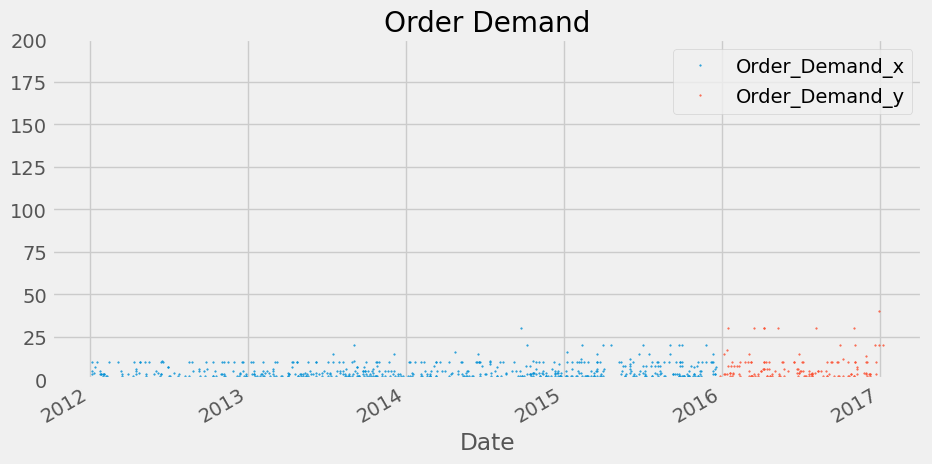

In [13]:
split_date = '22-DEC-2015'
# df['Order_Demand'] = df['Order_Demand'].str.replace('[^0-9-]','').apply(np.int64)
df_train = df.loc[df.Date <= split_date].copy()
df_test = df.loc[df.Date > split_date].copy()

# Plot train and test so you can see where we have split
# df_test \
#     .rename(columns={'df_demand': 'TEST SET'}) \
#     .join(df_train.rename(columns={'df_demand': 'TRAINING SET'}),
#           how='outer') \
#     .plot(figsize=(10, 5), title='Order Demand', style='.', ms=1)
# plt.show()
df_train.dtypes
# Plot train and test so you can see where we have split
# plot_df = df_train \
#     .rename(columns={'Order_Demand': 'TRAINING SET', 'Date': 'Training Date'}) \
#         .join(df_test.rename(columns={'Order_Demand': 'TEST SET', 'Date': 'Test Date'}),
#               how='outer')
# df_train.plot(figsize=(10, 5), title='Order Demand', style='.', ms=1, x='Date', y='Order_Demand')
# df_test.plot(figsize=(10, 5), title='Order Demand', style='.', ms=1, x='Date', y='Order_Demand')
# pd.merge(df_train, df_test, on='Date', how='outer').plot(figsize=(10, 5), title='Order Demand', style='.', ms=1, x='Date', y='Order_Demand')
pd.merge(df_train, df_test, on='Date', how='outer').plot(figsize=(10, 5), title='Order Demand', style='.', ms=1, x='Date')
plt.ylim(0, 200)



### Training Prophet Model

In [14]:
train = df_train.copy().reset_index(drop=True)
train.columns = ['ds', 'y']
train.sort_values('ds', inplace=True)
train

,ds,y
48,2012-01-05,10
17,2012-01-05,5
116,2012-01-05,3
112,2012-01-05,1
87,2012-01-11,4
...,...,...
655,2015-12-11,10
740,2015-12-15,3
578,2015-12-15,3
680,2015-12-16,6


In [15]:
%%time
model = Prophet()
model.fit(train)

01:34:26 - cmdstanpy - INFO - Chain [1] start processing
01:34:26 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 109 ms
Wall time: 438 ms


In [16]:
test = df_test.copy().reset_index(drop=True)
test.columns = ['ds', 'y']
test.sort_values(by='ds', inplace=True)
pred = model.predict(test)
# pred.sort_values(by='ds', inplace=True)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-28,6.386079,0.421489,9.749719,6.386079,6.386079,-1.133028,-1.133028,-1.133028,-1.158545,-1.158545,-1.158545,0.025517,0.025517,0.025517,0.0,0.0,0.0,5.253051
1,2016-01-05,6.403556,0.797868,10.936986,6.403556,6.403556,-0.730442,-0.730442,-0.730442,-1.127712,-1.127712,-1.127712,0.397270,0.397270,0.397270,0.0,0.0,0.0,5.673114
2,2016-01-05,6.403556,1.006468,10.756831,6.403556,6.403556,-0.730442,-0.730442,-0.730442,-1.127712,-1.127712,-1.127712,0.397270,0.397270,0.397270,0.0,0.0,0.0,5.673114
3,2016-01-07,6.407925,1.140958,10.726561,6.407925,6.407925,-0.505229,-0.505229,-0.505229,-0.901909,-0.901909,-0.901909,0.396680,0.396680,0.396680,0.0,0.0,0.0,5.902696
4,2016-01-12,6.418849,0.523728,10.631290,6.418849,6.418849,-0.932335,-0.932335,-0.932335,-1.127712,-1.127712,-1.127712,0.195377,0.195377,0.195377,0.0,0.0,0.0,5.486514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2016-12-21,7.170360,0.672606,10.528909,7.127822,7.215623,-1.483020,-1.483020,-1.483020,-1.129238,-1.129238,-1.129238,-0.353782,-0.353782,-0.353782,0.0,0.0,0.0,5.687339
172,2016-12-22,7.172544,1.085711,11.338772,7.129787,7.218437,-1.207055,-1.207055,-1.207055,-0.901909,-0.901909,-0.901909,-0.305146,-0.305146,-0.305146,0.0,0.0,0.0,5.965489
173,2016-12-28,7.185652,1.393992,11.208930,7.142515,7.232243,-1.053610,-1.053610,-1.053610,-1.129238,-1.129238,-1.129238,0.075628,0.075628,0.075628,0.0,0.0,0.0,6.132042
174,2016-12-28,7.185652,1.233898,11.334811,7.142238,7.232872,-1.053610,-1.053610,-1.053610,-1.129238,-1.129238,-1.129238,0.075628,0.075628,0.075628,0.0,0.0,0.0,6.132042


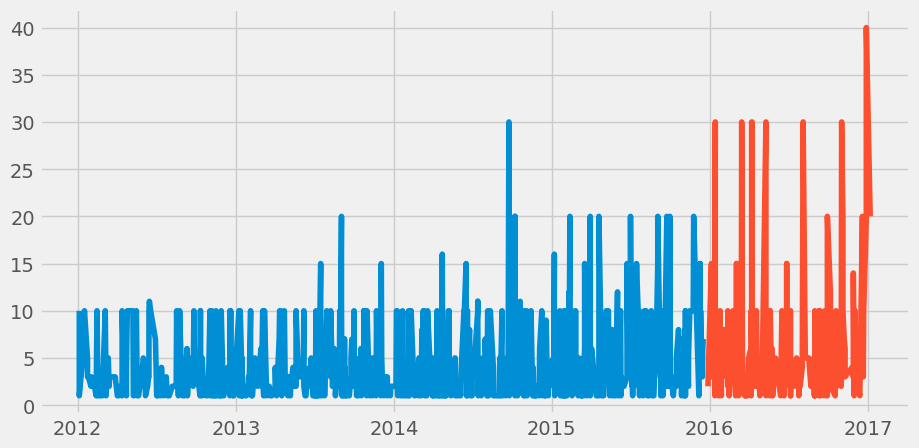

In [17]:
# Plot train and test so you can see where we have split
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')

In [18]:
# metrics for to analyze the performance of the model
print('MAE: {}'.format(mean_absolute_error(test['y'], pred['yhat'])))
print('MSE: {}'.format(mean_squared_error(test['y'], pred['yhat'])))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test['y'], pred['yhat']))))
print('Mean Absolute Percentage Error: {}'.format(mean_absolute_percentage_error(y_true=test['y'], y_pred=pred['yhat'])))


MAE: 4.754125820579465
MSE: 50.26378556785132
RMSE: 7.089695731683506
Mean Absolute Percentage Error: 151.51734419872474


In [19]:
pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
171,2016-12-21,7.170360,0.672606,10.528909,7.127822,7.215623,-1.483020,-1.483020,-1.483020,-1.129238,-1.129238,-1.129238,-0.353782,-0.353782,-0.353782,0.0,0.0,0.0,5.687339
172,2016-12-22,7.172544,1.085711,11.338772,7.129787,7.218437,-1.207055,-1.207055,-1.207055,-0.901909,-0.901909,-0.901909,-0.305146,-0.305146,-0.305146,0.0,0.0,0.0,5.965489
173,2016-12-28,7.185652,1.393992,11.208930,7.142515,7.232243,-1.053610,-1.053610,-1.053610,-1.129238,-1.129238,-1.129238,0.075628,0.075628,0.075628,0.0,0.0,0.0,6.132042
174,2016-12-28,7.185652,1.233898,11.334811,7.142238,7.232872,-1.053610,-1.053610,-1.053610,-1.129238,-1.129238,-1.129238,0.075628,0.075628,0.075628,0.0,0.0,0.0,6.132042
175,2017-01-06,7.205314,1.366675,10.863201,7.161357,7.252891,-1.001796,-1.001796,-1.001796,-1.401136,-1.401136,-1.401136,0.399340,0.399340,0.399340,0.0,0.0,0.0,6.203517


In [20]:
test.tail()

,ds,y
22,2016-12-21,3
121,2016-12-22,10
62,2016-12-28,20
122,2016-12-28,40
60,2017-01-06,20


### Comparing forecasted values with actual values

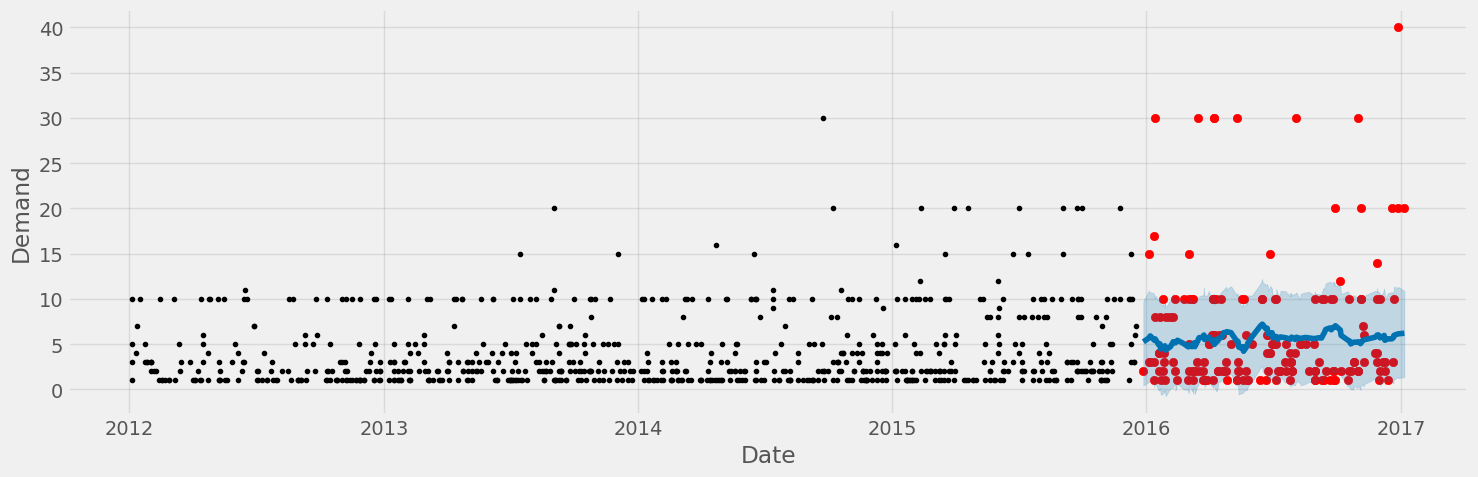

In [21]:
#plot forecast with actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test['ds'], test['y'], color='r', label='Actual')
fig = model.plot(pred, ax=ax, xlabel='Date', ylabel='Demand')


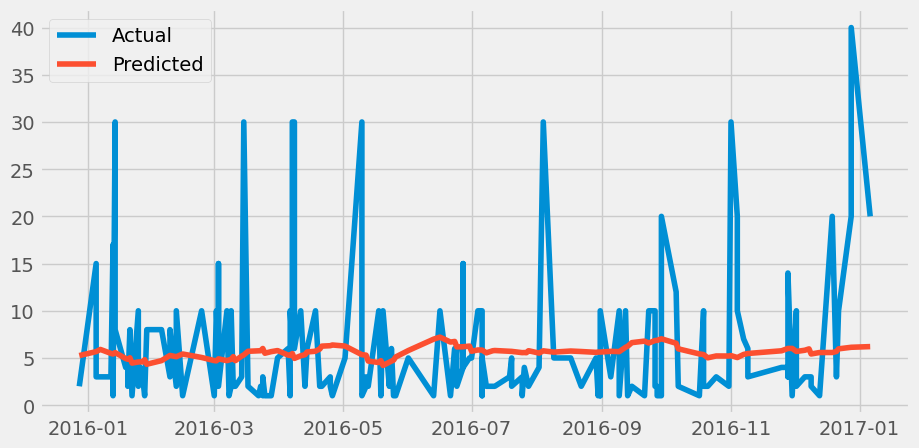

In [22]:
#comparing actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], pred['yhat'], label='Predicted')
plt.legend()

### Predict into the future

In [23]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model.predict(future)

In [24]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-17 01:00:00,6.362139,0.143827,9.810313,6.362139,6.362139,-1.409304,-1.409304,-1.409304,-0.934067,-0.934067,-0.934067,-0.475237,-0.475237,-0.475237,0.0,0.0,0.0,4.952835
1,2015-12-17 02:00:00,6.362230,-0.014789,9.852204,6.362230,6.362230,-1.445304,-1.445304,-1.445304,-0.970298,-0.970298,-0.970298,-0.475006,-0.475006,-0.475006,0.0,0.0,0.0,4.916926
2,2015-12-17 03:00:00,6.362321,-0.423707,9.569059,6.362321,6.362321,-1.484979,-1.484979,-1.484979,-1.010219,-1.010219,-1.010219,-0.474759,-0.474759,-0.474759,0.0,0.0,0.0,4.877343
3,2015-12-17 04:00:00,6.362412,-0.228046,9.956239,6.362412,6.362412,-1.527862,-1.527862,-1.527862,-1.053364,-1.053364,-1.053364,-0.474498,-0.474498,-0.474498,0.0,0.0,0.0,4.834551
4,2015-12-17 05:00:00,6.362503,-0.034043,9.524099,6.362503,6.362503,-1.573409,-1.573409,-1.573409,-1.099188,-1.099188,-1.099188,-0.474221,-0.474221,-0.474221,0.0,0.0,0.0,4.789094


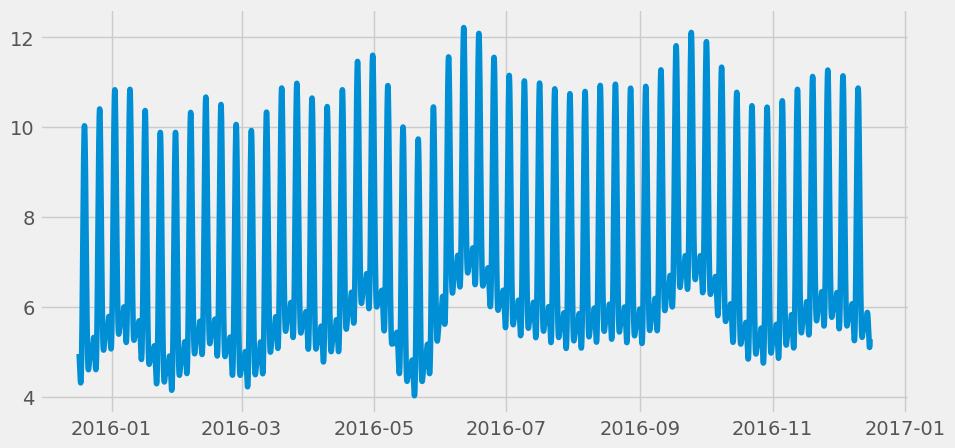

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')